In [1]:
%matplotlib inline
import os
import collections
import torch
import torchvision
import numpy as np
import scipy.misc as m
import scipy.io as io
import matplotlib.pyplot as plt

from torch.utils import data

os.environ['CUDA_VISIBLE_DEVICES'] = '3'

def recursive_glob(rootdir='.', suffix=''):
    """Performs recursive glob with given suffix and rootdir 
        :param rootdir is the root directory
        :param suffix is the suffix to be searched
    """
    return [os.path.join(looproot, filename)
        for looproot, _, filenames in os.walk(rootdir)
        for filename in filenames if filename.endswith(suffix)]


In [2]:
class SUNRGBDLoader(data.Dataset):
    def __init__(self, root, split="training", is_transform=False, img_size=(480, 640), img_norm=True):
        self.root = root
        self.is_transform = is_transform
        self.n_classes = 38
        self.img_norm = img_norm
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)
        self.mean = np.array([104.00699, 116.66877, 122.67892])
        self.color_files = collections.defaultdict(list)
        self.depth_files = collections.defaultdict(list)
        self.semantic_files = collections.defaultdict(list)
        self.cmap = self.color_map(normalized=False)

        split_map = {"training": 'train', "val": 'test',}
        self.split = split_map[split]

        for split in ["train", "test"]:
            file_list =  sorted(recursive_glob(rootdir=self.root + '/color/', suffix='jpg'))
            self.color_files[split] = file_list
        
        for split in ["train", "test"]:
            file_list =  sorted(recursive_glob(rootdir=self.root + '/depth/', suffix='png'))
            self.depth_files[split] = file_list    
        
        for split in ["train", "test"]:
            file_list =  sorted(recursive_glob(rootdir=self.root + '/seg/', suffix='png'))
            self.semantic_files[split] = file_list


    def __len__(self):
        return len(self.color_files[self.split])


    def __getitem__(self, index):
        color_path = self.color_files[self.split][index].rstrip()
        depth_path = self.depth_files[self.split][index].rstrip()
        semantic_path = self.semantic_files[self.split][index].rstrip()

        color_img = m.imread(color_path)    
        color_img = np.array(color_img, dtype=np.uint8)

        depth_img = m.imread(depth_path)    
        depth_img = np.array(depth_img, dtype=np.uint8)
        
        semantic_img = m.imread(semantic_path)
        semantic_img = np.array(semantic_img, dtype=np.uint8)
        
        if self.is_transform:
            color_img, semantic_img = self.transform(color_img, semantic_img)
        
        return color_img, depth_img, semantic_img


    def transform(self, img, lbl):
        img = m.imresize(img, (self.img_size[0], self.img_size[1])) # uint8 with RGB mode
        img = img[:, :, ::-1] # RGB -> BGR
        img = img.astype(np.float64)
        img -= self.mean
        if self.img_norm:
            # Resize scales images from 0 to 255, thus we need
            # to divide by 255.0
            img = img.astype(float) / 255.0
        # NHWC -> NCHW
        img = img.transpose(2, 0, 1)

        classes = np.unique(lbl)
        lbl = lbl.astype(float)
        lbl = m.imresize(lbl, (self.img_size[0], self.img_size[1]), 'nearest', mode='F')
        lbl = lbl.astype(int)
        assert(np.all(classes == np.unique(lbl)))

        img = torch.from_numpy(img).float()
        lbl = torch.from_numpy(lbl).long()
        return img, lbl


    def color_map(self, N=256, normalized=False):
        """
        Return Color Map in PASCAL VOC format
        """

        def bitget(byteval, idx):
            return ((byteval & (1 << idx)) != 0)

        dtype = 'float32' if normalized else 'uint8'
        cmap = np.zeros((N, 3), dtype=dtype)
        for i in range(N):
            r = g = b = 0
            c = i
            for j in range(8):
                r = r | (bitget(c, 0) << 7-j)
                g = g | (bitget(c, 1) << 7-j)
                b = b | (bitget(c, 2) << 7-j)
                c = c >> 3

            cmap[i] = np.array([r, g, b])

        cmap = cmap/255.0 if normalized else cmap
        return cmap


    def decode_segmap(self, temp):
        r = temp.copy()
        g = temp.copy()
        b = temp.copy()
        for l in range(0, self.n_classes):
            r[temp == l] = self.cmap[l,0]
            g[temp == l] = self.cmap[l,1]
            b[temp == l] = self.cmap[l,2]

        rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        return rgb

In [3]:
import sys, os
import torch
import visdom
import argparse
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

from torch.autograd import Variable
from torch.utils import data
from tqdm import tqdm

from ptsemseg.models import get_model
from ptsemseg.loader import get_loader, get_data_path
from ptsemseg.metrics import runningScore
from ptsemseg.loss import *
from ptsemseg.augmentations import *


parser = argparse.ArgumentParser(description='Hyperparams')
parser.add_argument('--arch', nargs='?', type=str, default='fcn8s', 
                    help='Architecture to use [\'fcn8s, unet, segnet etc\']')
parser.add_argument('--img_rows', nargs='?', type=int, default=256, 
                    help='Height of the input image')
parser.add_argument('--img_cols', nargs='?', type=int, default=256, 
                    help='Width of the input image')

parser.add_argument('--img_norm', dest='img_norm', action='store_true', 
                    help='Enable input image scales normalization [0, 1] | True by default')
parser.add_argument('--no-img_norm', dest='img_norm', action='store_false', 
                    help='Disable input image scales normalization [0, 1] | True by default')
parser.set_defaults(img_norm=True)

parser.add_argument('--n_epoch', nargs='?', type=int, default=100, 
                    help='# of the epochs')
parser.add_argument('--batch_size', nargs='?', type=int, default=1, 
                    help='Batch Size')
parser.add_argument('--l_rate', nargs='?', type=float, default=1e-5, 
                    help='Learning Rate')
parser.add_argument('--feature_scale', nargs='?', type=int, default=1, 
                    help='Divider for # of features to use')
parser.add_argument('--resume', nargs='?', type=str, default=None,    
                    help='Path to previous saved model to restart from')

parser.add_argument('--visdom', dest='visdom', action='store_true', 
                    help='Enable visualization(s) on visdom | False by default')
parser.add_argument('--no-visdom', dest='visdom', action='store_false', 
                    help='Disable visualization(s) on visdom | False by default')
parser.set_defaults(visdom=False)

# args = parser.parse_args('--arch fcn8s'.split(' '))
# train(args)

In [5]:
args = parser.parse_args('--arch fcn8s'.split(' '))

# Setup Augmentations
data_aug= Compose([RandomRotate(10),                                        
                   RandomHorizontallyFlip()])

# Setup Dataloader
data_path = '/home/dongwonshin/Desktop/Datasets/SUN_RGBD(organized)/temp'
t_loader = SUNRGBDLoader(data_path, is_transform=True)
v_loader = SUNRGBDLoader(data_path, is_transform=True, split='val')

n_classes = t_loader.n_classes
trainloader = data.DataLoader(t_loader, batch_size=args.batch_size, num_workers=16, shuffle=True)
valloader = data.DataLoader(v_loader, batch_size=args.batch_size, num_workers=16)

# Setup Metrics
running_metrics = runningScore(n_classes)

# Setup visdom for visualization
if args.visdom:
    vis = visdom.Visdom()

    loss_window = vis.line(X=torch.zeros((1,)).cpu(),
                       Y=torch.zeros((1)).cpu(),
                       opts=dict(xlabel='minibatches',
                                 ylabel='Loss',
                                 title='Training Loss',
                                 legend=['Loss']))

# Setup Model
model = get_model(args.arch, n_classes)

model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))
model.cuda()

# Check if model has custom optimizer / loss
if hasattr(model.module, 'optimizer'):
    optimizer = model.module.optimizer
else:
    optimizer = torch.optim.SGD(model.parameters(), lr=args.l_rate, momentum=0.99, weight_decay=5e-4)

if hasattr(model.module, 'loss'):
    print('Using custom loss')
    loss_fn = model.module.loss
else:
    loss_fn = cross_entropy2d

if args.resume is not None:                                         
    if os.path.isfile(args.resume):
        print("Loading model and optimizer from checkpoint '{}'".format(args.resume))
        checkpoint = torch.load(args.resume)
        model.load_state_dict(checkpoint['model_state'])
        optimizer.load_state_dict(checkpoint['optimizer_state'])
        print("Loaded checkpoint '{}' (epoch {})"                    
              .format(args.resume, checkpoint['epoch']))
    else:
        print("No checkpoint found at '{}'".format(args.resume)) 


In [32]:
color_imgs, depth_imgs, semantic_imgs = iter(trainloader).next()
images = Variable(color_imgs.cuda())
labels = Variable(semantic_imgs.cuda())

In [33]:
optimizer.zero_grad()
outputs = model(images)

/home/dongwonshin/.conda/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1462: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.")


In [34]:
input = outputs
target = labels
n, c, h, w = input.size()
nt, ht, wt = target.size()

In [35]:
# Handle inconsistent size between input and target
if h > ht and w > wt: # upsample labels
    target = target.unsequeeze(1)
    target = F.upsample(target, size=(h, w), mode='nearest')
    target = target.sequeeze(1)
elif h < ht and w < wt: # upsample images
    input = F.upsample(input, size=(ht, wt), mode='bilinear')
elif h != ht and w != wt:
    raise Exception("Only support upsampling")

In [36]:
log_p = F.log_softmax(input, dim=1)

In [37]:
log_p = log_p.transpose(1, 2).transpose(2, 3).contiguous().view(-1, c)
log_p = log_p[target.view(-1, 1).repeat(1, c) >= 0]
log_p = log_p.view(-1, c)

In [56]:
mask = target >= 0
# target = target[mask]
target = Variable(torch.cuda.LongTensor(307200).fill_(0))

### 2018년 05월 08일 11시 17분 56초에 추가
확실히.. 세만틱 이미지를 불러와서 쓰는데 문제가 있다..
클래스 값이.. 저장된것이 색상으로 저장되어서.. 
그게 로스 함수 계산할때.. 문제가된다.. 
이것을 컨버팅 해주는 루틴이 필요하다..

SUNRGBDloader의 transform에서 작업을 해줘야할것같다..

In [57]:
log_p

Variable containing:
 -5.0421  -4.8467  -8.9306  ...   -6.6899  -3.6626  -6.9615
 -4.9404  -4.5488  -8.5733  ...   -6.4881  -3.5655  -6.7985
 -4.8502  -4.2623  -8.2276  ...   -6.2978  -3.4798  -6.6470
           ...               ⋱              ...            
 -5.3898  -4.3915  -4.2632  ...   -5.0559  -3.6877  -6.3092
 -5.4211  -4.4630  -4.3092  ...   -5.1669  -3.7845  -6.4959
 -5.4552  -4.5374  -4.3581  ...   -5.2808  -3.8841  -6.6855
[torch.cuda.FloatTensor of size 307200x38 (GPU 0)]

In [58]:
target

Variable containing:
 0
 0
 0
⋮ 
 0
 0
 0
[torch.cuda.LongTensor of size 307200 (GPU 0)]

In [59]:
loss = F.nll_loss(log_p, target, ignore_index=250, size_average=True)

In [60]:
loss

Variable containing:
 4.8452
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [61]:
loss /= mask.data.sum()

In [62]:
# loss = loss_fn(input=outputs, target=labels)

loss.backward()
optimizer.step()

In [14]:
best_iou = -100.0 
model.train()
for i, (color_imgs, depth_imgs, semantic_imgs) in enumerate(trainloader):
    images = Variable(color_imgs.cuda())
    labels = Variable(semantic_imgs.cuda())

    optimizer.zero_grad()
    outputs = model(images)

    loss = loss_fn(input=outputs, target=labels)

    loss.backward()
    optimizer.step()
    
    print(i)

/home/dongwonshin/.conda/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1462: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.")


RuntimeError: cuda runtime error (59) : device-side assert triggered at /opt/conda/conda-bld/pytorch_1522182087074/work/torch/lib/THC/generated/../THCReduceAll.cuh:339

In [68]:
semantic_img = m.imread('/home/dongwonshin/Desktop/Datasets/SUN_RGBD(organized)/temp/seg/NYUdata_NYU1408_seg.png')
semantic_img = np.array(semantic_img, dtype=np.uint8)

lbl = semantic_img

classes = np.unique(lbl)
lbl = lbl.astype(float)
lbl = m.imresize(lbl, (480, 640), 'nearest', mode='F')
lbl = lbl.astype(int)
assert(np.all(classes == np.unique(lbl)))

lbl = torch.from_numpy(lbl).long()

In [70]:
np.unique(lbl)

array([  0,   2,   4,   8,  12,  15,  27,  42,  49,  65, 109, 255])

SUNRGBD 데이터셋에서 segmentation 이미지를 mat파일 형태로 제공..
근데 예전에 바꿀때.. 저장을 클래스 레이블로 하지않고.. 자동으로 색상으로 변경되어서 저장된것같다..
다시 organization을 해줘야할것같다

In [86]:
import scipy
mat_file= scipy.io.loadmat('/home/dongwonshin/Desktop/Datasets/SUNRGBD2/SUNRGBD/kv1/b3dodata/img_0063/seg.mat')

In [87]:
mat_file

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Mon May  4 15:31:06 2015',
 '__version__': '1.0',
 'names': array([[array(['wall'], 
       dtype='<U4'),
         array(['shelf'], 
       dtype='<U5'),
         array(['shelf'], 
       dtype='<U5'),
         array(['floor'], 
       dtype='<U5'),
         array(['chair'], 
       dtype='<U5'),
         array(['books'], 
       dtype='<U5'),
         array(['books'], 
       dtype='<U5'),
         array(['box'], 
       dtype='<U3'),
         array(['books'], 
       dtype='<U5')]], dtype=object),
 'seglabel': array([[2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        ..., 
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 2, ..., 0, 0, 0]], dtype=uint8)}

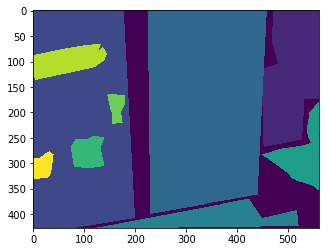

In [89]:
plt.imshow(mat_file['seglabel'])